In [1]:
import numpy as np
from keras.preprocessing.text import Tokenizer

/Users/frederiknakstad/Dev/sandbox/deep-learning-with-python-notebook/venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print word_index

Found 9 unique tokens.
{'on': 4, 'ate': 7, 'mat': 5, 'dog': 6, 'cat': 2, 'the': 1, 'my': 8, 'homework': 9, 'sat': 3}


# Word embeddings

In [3]:
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64)

In [4]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 66us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 1s 45us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 1s 44us/step - loss: 

In [6]:
import os

imdb_dir = '/Users/frederiknakstad/Dev/sandbox/deep-learning-with-python-notebook/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88584 unique tokens.
('Shape of data tensor:', (25000, 100))
('Shape of label tensor:', (25000,))


In [8]:
glove_dir = '/Users/frederiknakstad/Dev/sandbox/deep-learning-with-python-notebook/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [9]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [12]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 1.9450 - acc: 0.5050 - val_loss: 0.6939 - val_acc: 0.5127
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5853 - acc: 0.7000 - val_loss: 0.7965 - val_acc: 0.5117
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5177 - acc: 0.7400 - val_loss: 0.6902 - val_acc: 0.5704
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4070 - acc: 0.8150 - val_loss: 0.9662 - val_acc: 0.4960
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2635 - acc: 0.9000 - val_loss: 1.2108 - val_acc: 0.5156
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3211 - acc: 0.8350 - val_loss: 0.8698 - val_acc: 0.5240
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1116 - acc: 0.9800 - val_loss: 0.7678 - val_acc: 0.5544
Epoch 8/10
200/200 [========

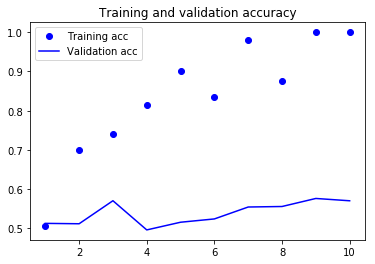

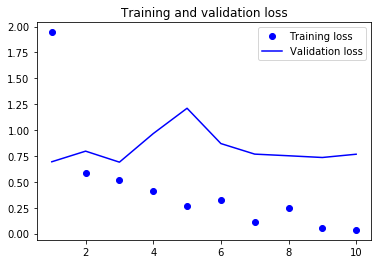

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 0.6941 - acc: 0.4950 - val_loss: 0.6955 - val_acc: 0.5179
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5001 - a